In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Crop images

In [5]:
# load sam
from src.model.sam import CustomSamAutomaticMaskGenerator, load_sam
from segment_anything.modeling.sam import Sam
model_type = "vit_h"
checkpoint_dir =  "datasets/bop23_challenge/pretrained/segment-anything"
sam_model = load_sam(model_type, checkpoint_dir)
custom_sam_model = CustomSamAutomaticMaskGenerator(sam=sam_model)

In [6]:
def move_to_device(segmentor_model, device="cuda:0"):
    # if there is predictor in the model, move it to device
    if hasattr(segmentor_model, "predictor"):
        segmentor_model.predictor.model = (
            segmentor_model.predictor.model.to(device)
        )
    else:
        segmentor_model.model.setup_model(device=device, verbose=True)
move_to_device(custom_sam_model)

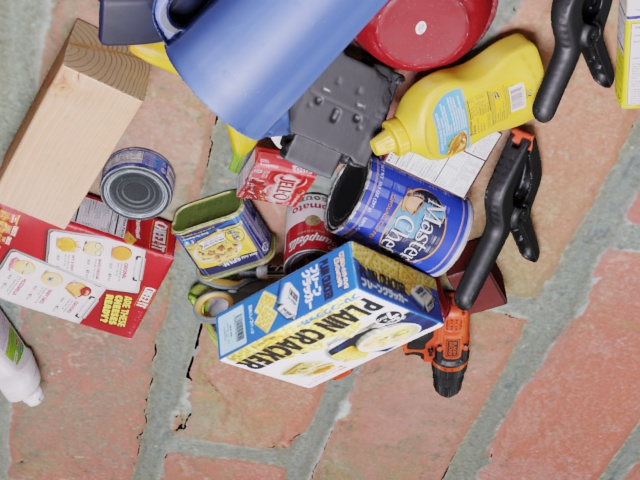

In [13]:
from PIL import Image
import torch
import numpy as np
from src.model.utils import Detections

dataset = "ycbv"
rgb_path = f"datasets/bop23_challenge/datasets/{dataset}/train_pbr/000000/rgb/000002.jpg"
rgb = Image.open(rgb_path).convert("RGB")
detections = custom_sam_model.generate_masks(np.array(rgb))
rgb

In [10]:
def extract_object_by_mask(image, mask, width: int = 512):
    mask = Image.fromarray(mask)
    masked_image = Image.composite(
        image, Image.new("RGB", image.size, (0, 0, 0)), mask)
    cropped_image = masked_image.crop(masked_image.getbbox())
    # new_height = width * cropped_image.height // cropped_image.width
    return cropped_image

masked_images = []
for mask in detections["masks"].cpu():
    binary_mask = np.array(mask) * 255
    binary_mask = binary_mask.astype(np.uint8)
    masked_image = extract_object_by_mask(rgb, binary_mask)
    masked_images.append(masked_image)

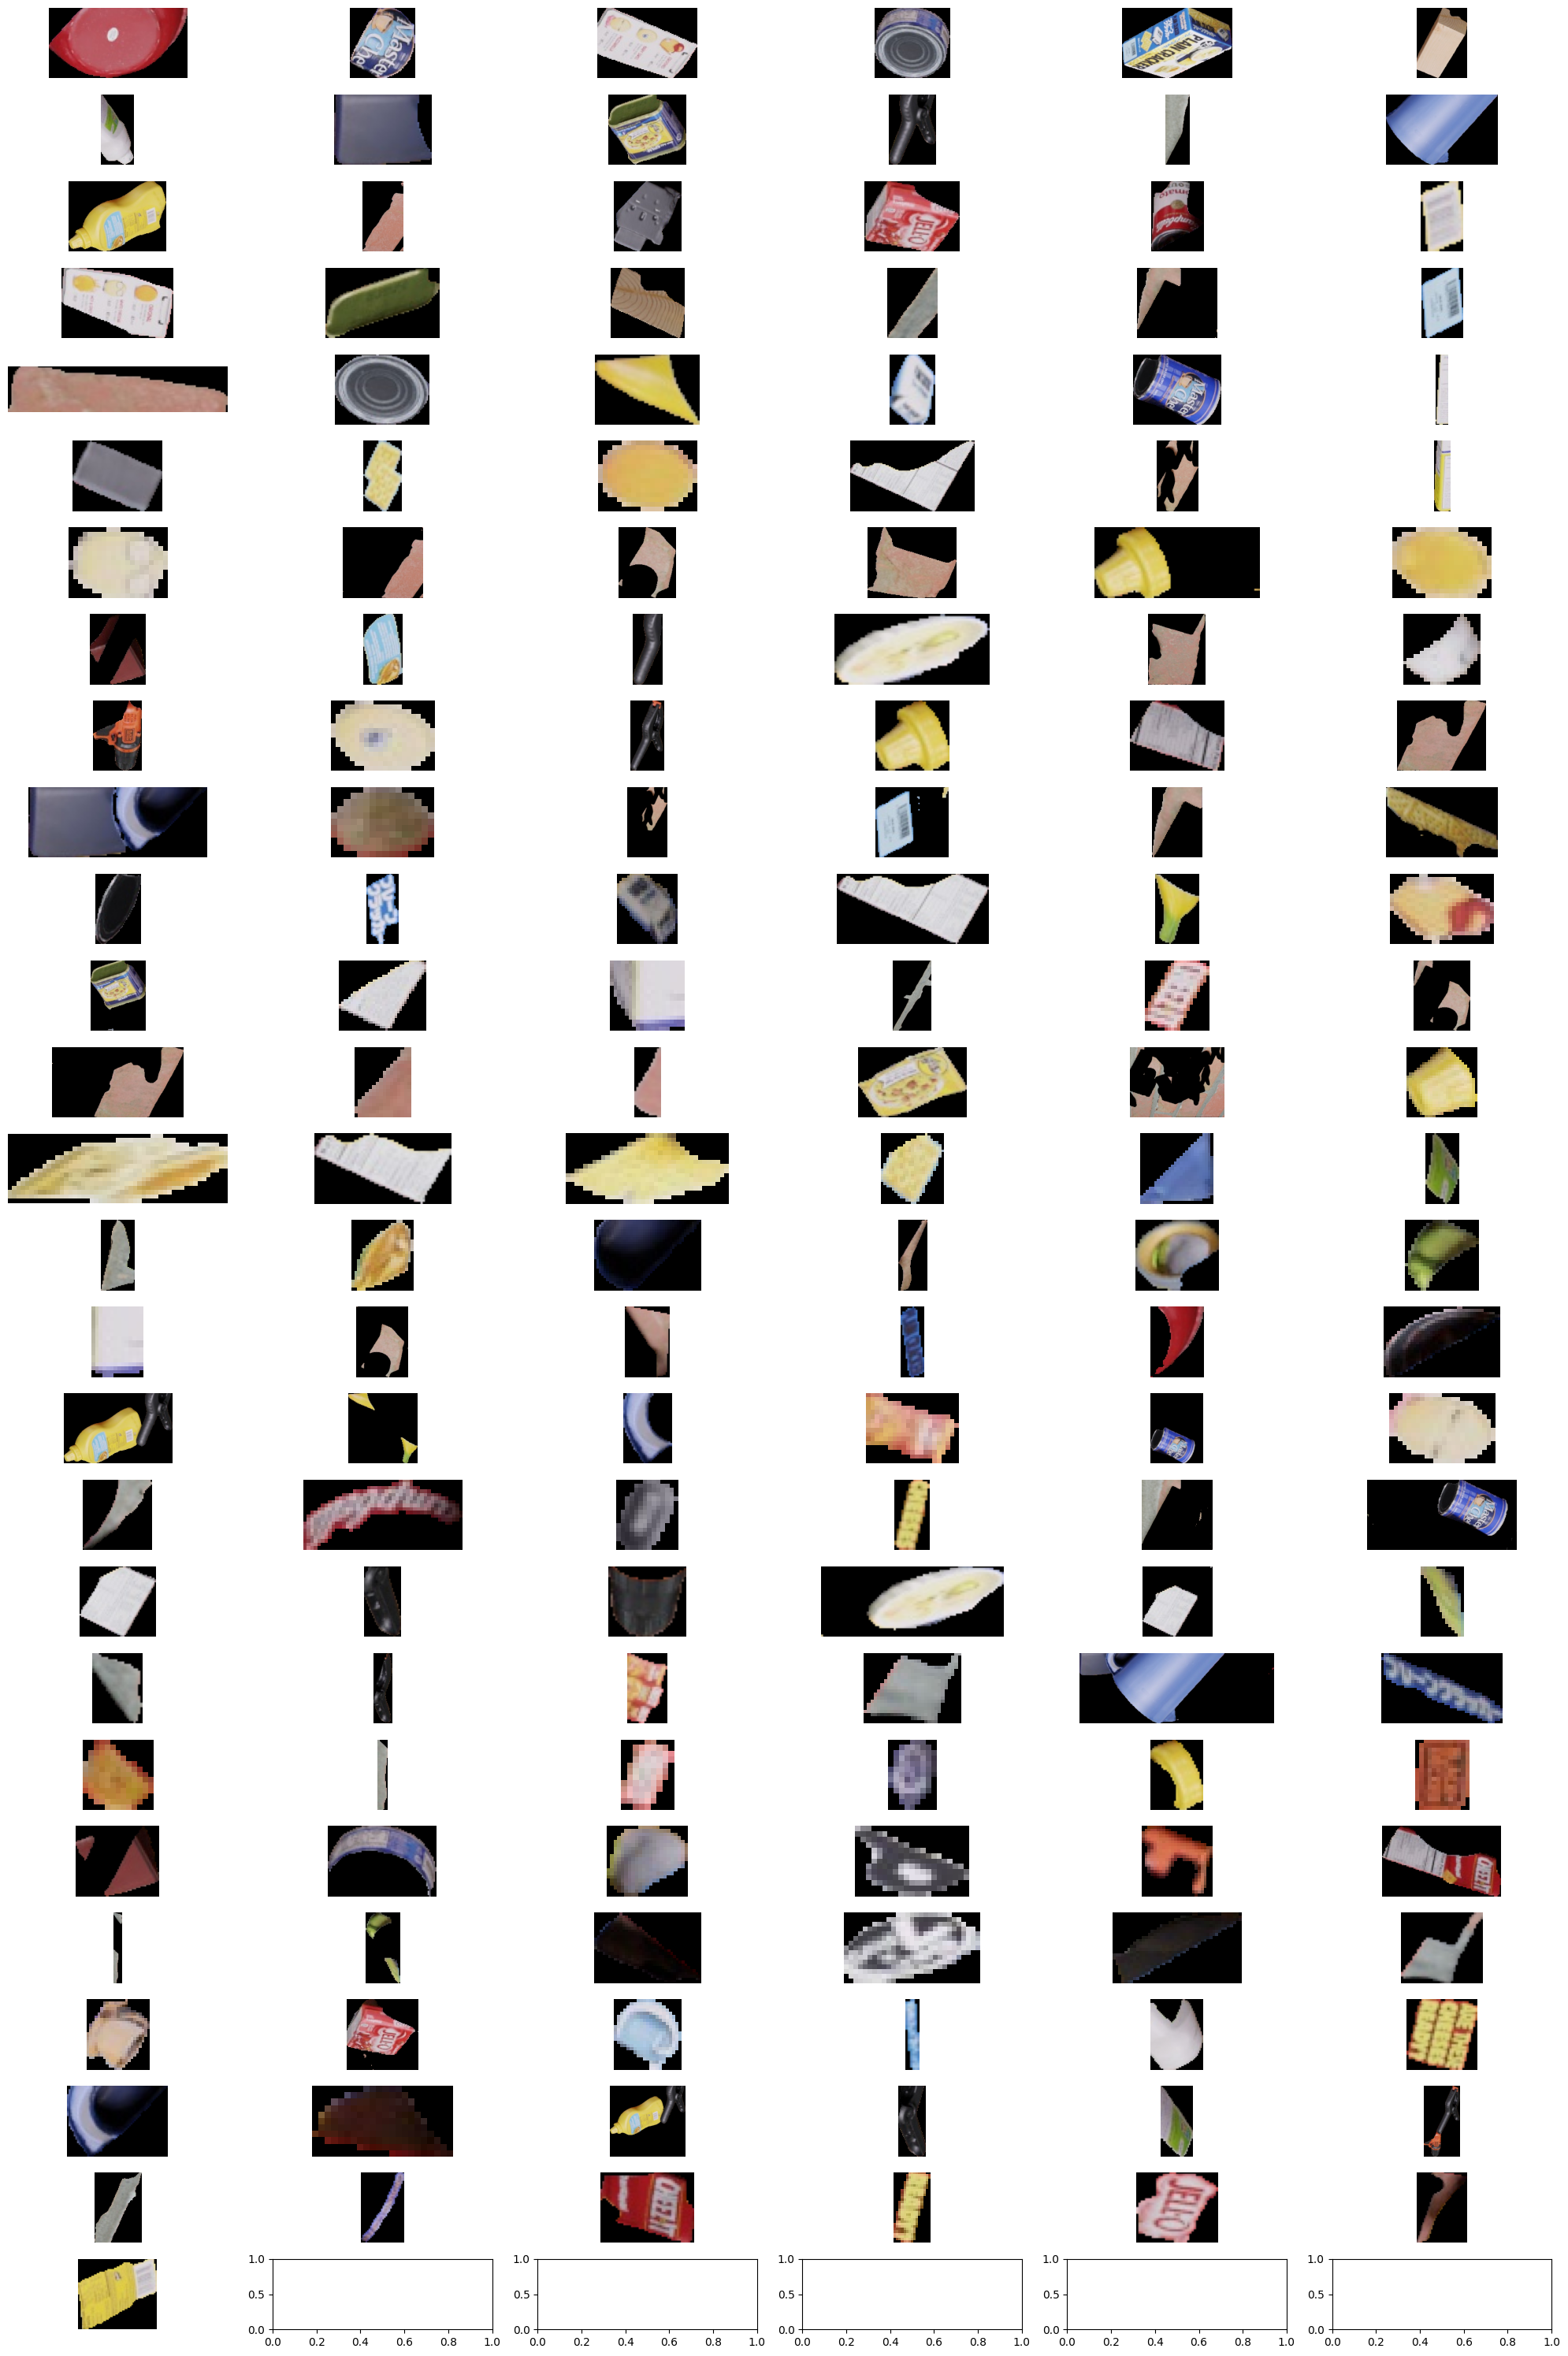

In [12]:
# Visualize proposals
import matplotlib.pyplot as plt
from math import ceil
def plot_images(images, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 30))
    for i, ax in enumerate(axes.flat):
        if i >= len(images):
            break
        ax.imshow(images[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Define the number of rows and columns in the grid
rows = ceil(len(masked_images) / 6)
cols = 6
# Plot the masked_images array in a grid
plot_images(masked_images, rows, cols) 

In [15]:
import os

# Choose crop 29
crop_idx = 28
crop1 = {
    "crop" : masked_images[crop_idx], # it is saved as Image so crop1["crop"] to visualize it
    "masks" : detections["masks"][crop_idx],
    "boxes" : detections["boxes"][crop_idx]
}
# save image
if not os.path.exists(f"foundpose_analysis/{dataset}"):
    os.makedirs(f"foundpose_analysis/{dataset}")
crop1["crop"].save(f"foundpose_analysis/{dataset}/crop1.png")

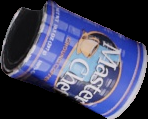

In [16]:
crop1["crop"]

# 2. Templates

## 2.1 Create templates of object

In [18]:
# load config file
import hydra
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, compose

# Initialize Hydra and compose the configuration
initialize(config_path="configs")
cfg = compose(config_name="run_inference")
OmegaConf.set_struct(cfg, False)

/tmp/ipykernel_2084216/531409554.py:7: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="configs")


In [23]:
import os
import glob

default_ref_dataloader_config = cfg.data.reference_dataloader
ref_dataloader_config = default_ref_dataloader_config.copy()
ref_dataloader_config._target_ = "src.dataloader.bop_pbr.BOPTemplatePBR"
ref_dataloader_config.root_dir = f"datasets/bop23_challenge/datasets/{dataset}"
ref_dataloader_config.template_dir = " "

level_template = 1 # Level 0 :42 templates, level 1, 162 templates
ref_dataloader_config.level_templates = level_template 
ref_dataloader_config.split = "train_pbr"

ply_files = glob.glob(f"datasets/bop23_challenge/datasets/{dataset}/models/models/*.ply")
obj_ids = sorted([int(os.path.basename(obj_id)[8:10]) for obj_id in ply_files])
ref_dataloader_config.obj_ids = obj_ids

out_folder = f"foundpose_analysis/{dataset}/templates"
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
ref_dataloader_config.out_dir = out_folder
ref_dataloader_config.templates_output_folder = f"{out_folder}/level_template_{level_template}"

In [24]:
from hydra.utils import instantiate
ref_dataset = instantiate(ref_dataloader_config) # src.dataloader.bop.BOPTemplatePBR
ref_dataset.load_processed_metaData(reset_metaData=True)

Loading metaData: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]
Finding nearest rendering close to template poses: 100%|██████████| 21/21 [00:00<00:00, 124.29it/s]


In [26]:
from torchvision.utils import save_image
import pandas as pd

templates = pd.read_csv(f"{out_folder}/train_pbr_processed_metaData.csv")

# Save templates as images
for ob_id in range(1,len(obj_ids)+1): 
    obj_id_path = os.path.join(f"{out_folder}/synthetic_images_templates/{dataset}/train_pbr", f'obj_{(ob_id):06d}') # The transformed templates - check line 244, 245 in bop_pbr.py
    original_obj_id_path = os.path.join(f"{out_folder}/synthetic_images_templates/{dataset}/train_pbr", f'obj_{(ob_id):06d}_original')
    
    if not os.path.exists(obj_id_path):
        os.makedirs(obj_id_path)
    if not os.path.exists(original_obj_id_path):
        os.makedirs(original_obj_id_path)

    for i, img in enumerate(ref_dataset[ob_id-1]["templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
        save_image(img, os.path.join(obj_id_path, f'{i:06d}.png'))
    for i, img in enumerate(ref_dataset[ob_id-1]["original_templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
        save_image(img, os.path.join(original_obj_id_path, f'{i:06d}.png'))

## 2.2. Patch descriptors register in 3D for templates

In [100]:
import glob
import os

obj_id = 1
# Load original templates when before putting through dinov2 we also apply transfomation.
template_path = f"{out_folder}/synthetic_images_templates/{dataset}/train_pbr/obj_{obj_id:06d}_original" 
template_files = sorted(glob.glob(os.path.join(template_path, "*.png")), key=os.path.getmtime)
num_templates = len(template_files)

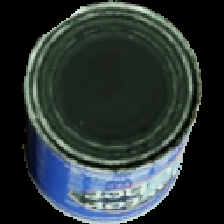

In [104]:
Image.open(template_files[2])

In [105]:
from PIL import Image
import numpy as np

templates = [np.array(Image.open(template_file).convert("RGB").resize((420,420)))[:,:,:3] for template_file in template_files] # This image has 4 channels- the last one is not crucial - maybe about opacity

In [106]:
import torchvision.transforms as T
import torch.nn.functional as F
import torch

def patches_feature_extraction(template_patches, dinov2_vitl14, device):
    # crop_rgb: numpy array
    # temps = np.transpose(np.array(template_patches), (0,2,3,1))
    rgb_normalize = T.Compose(
        [
            T.ToTensor(),
            T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ]
    )
    normalized_patches = torch.stack([rgb_normalize(patch) for patch in template_patches])
    layers_list = list(range(18))
    torch.cuda.empty_cache()
    with torch.no_grad(): 
        feature_patches= dinov2_vitl14.module.get_intermediate_layers(normalized_patches.to(device), n=layers_list, reshape=True, return_class_token=True)
    return feature_patches[-1][0] # Choose the last features as the feature after the 18th layer, 1 fo class token

In [107]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2_vitl14.patch_size = 14
if torch.cuda.is_available():
    dinov2_vitl14 = torch.nn.DataParallel(dinov2_vitl14).to(device)  # Use DataParallel for multiple GPUs

Using cache found in /home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main


In [108]:
batch_size = 16
template_batches = [templates[i:i+batch_size] for i in range(0, len(templates), batch_size)]
patch_features= list()

for batch in template_batches:
    torch.cuda.empty_cache()
    batch_feature = patches_feature_extraction(batch, dinov2_vitl14, device)
    patch_features.append(batch_feature.to('cpu'))
    del batch_feature
patch_features = torch.cat(patch_features).permute(0,2,3,1)

In [109]:
patch_features.shape

torch.Size([162, 30, 30, 1024])

In [110]:
del dinov2_vitl14

In [111]:
patch_features = patch_features.reshape(num_templates,-1,1024)
patch_features.shape

torch.Size([162, 900, 1024])

## 2.3 Filter out invalid templates 
Resize the mask to 30*30 and then choose the pixel position e.g (1,1) then check if mask[1,1] = 1 then the patch [1,1] is valid, otherwise it isn't

In [112]:
resized_templates = [np.array(Image.open(template_file).convert("RGB").resize((30,30)))[:,:,:3] for template_file in template_files] # This image has 4 channels- the last one is not crucial - maybe about opacity

In [113]:
# Mask out the templates by clampping at 0,1 
masks = np.clip(np.sum(resized_templates, axis=-1), 0, 1).reshape(num_templates,-1)
masks.shape

(162, 900)

In [114]:
num_valid_patches = list() # List of numbers of valid patches for each template
valid_patch_features = list()
for patch_feature, mask in zip(patch_features, masks):
    valid_patches = patch_feature[mask==1]
    valid_patch_features.append(valid_patches)
    num_valid_patches.append(valid_patches.shape[0]) # Append number of  valid patches for the template to the list
valid_patch_features = torch.cat(valid_patch_features)

In [115]:
print(valid_patch_features.shape)
print(len(num_valid_patches))
num_valid_patches

torch.Size([90518, 1024])
162


[668,
 654,
 630,
 642,
 678,
 567,
 579,
 558,
 553,
 638,
 646,
 589,
 552,
 543,
 574,
 568,
 602,
 567,
 576,
 557,
 489,
 488,
 510,
 467,
 505,
 528,
 506,
 542,
 549,
 489,
 543,
 505,
 485,
 577,
 508,
 530,
 493,
 525,
 505,
 542,
 608,
 543,
 518,
 546,
 547,
 544,
 595,
 553,
 559,
 518,
 570,
 559,
 659,
 458,
 500,
 615,
 631,
 534,
 519,
 560,
 473,
 518,
 499,
 574,
 498,
 547,
 575,
 503,
 644,
 589,
 479,
 628,
 549,
 609,
 511,
 466,
 500,
 604,
 662,
 560,
 614,
 499,
 542,
 546,
 484,
 636,
 468,
 474,
 522,
 553,
 548,
 439,
 527,
 557,
 757,
 573,
 598,
 558,
 662,
 525,
 531,
 546,
 490,
 642,
 523,
 456,
 538,
 475,
 559,
 579,
 532,
 559,
 546,
 600,
 544,
 565,
 558,
 548,
 542,
 503,
 519,
 545,
 556,
 506,
 661,
 535,
 573,
 546,
 565,
 585,
 665,
 480,
 559,
 533,
 545,
 473,
 522,
 533,
 619,
 522,
 537,
 576,
 534,
 537,
 623,
 524,
 595,
 578,
 619,
 588,
 556,
 680,
 538,
 577,
 488,
 643,
 570,
 688,
 664,
 722,
 712,
 658]

In [116]:
import numpy as np
from sklearn.decomposition import PCA

# Apply PCA with the 256 components to reduce dimensionality of the features
pca = PCA(n_components=256)
pca_patches_descriptors = pca.fit_transform(np.array(valid_patch_features.cpu()))
pca_patches_descriptors.shape

(90518, 256)

## 2.4 Perform Kmean clustering for all patch descriptors from templates (2048 clusters)

In [117]:
# https://github.com/facebookresearch/faiss/wiki/Faiss-building-blocks:-clustering,-PCA,-quantization
import faiss
ncentroids = 2048
niter = 20
verbose = True
d = pca_patches_descriptors.shape[1]
kmeans = faiss.Kmeans(d, ncentroids, niter=niter, verbose=verbose, gpu=True)
kmeans.train(pca_patches_descriptors)

Clustering 90518 points in 256D to 2048 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.01 s
  Iteration 19 (0.50 s, search 0.30 s): objective=1.3124e+08 imbalance=1.098 nsplit=0        


131240152.0

In [118]:
# Assign labels to the data points
labels = kmeans.index.search(pca_patches_descriptors, 1)[1]
labels.shape

(90518, 1)

In [119]:
templates_labels = list()
start_idx = 0
for num in num_valid_patches:
    end_idx = start_idx + num
    template_labels = labels[start_idx:end_idx].reshape(-1)
    templates_labels.append(template_labels)
    start_idx = end_idx

In [120]:
templates_labels[9].shape

(638,)

In [121]:
import math

def calculate_templates_vector(templates_labels, num_clusters = 2048):
    # Calculate bag-of-words descriptors of the templates

    templates_vector = list()
    all_occurrences = [np.bincount(templates_label, minlength=2048) for templates_label in templates_labels]
    ni_array = np.sum(np.array(all_occurrences), axis = 0)
    N = len(templates_labels) # Number of templates
    for t in range(len(templates_labels)):
        template_vector = list()
        occurrences = np.bincount(templates_labels[t], minlength=2048)
        for i in range(num_clusters):
            n_it = occurrences[i]
            nt = len(templates_labels[t])
            ni = ni_array[i]
            if ni==0 or nt==0:
                print(i)
            bi = n_it / nt * math.log(N / ni)
            template_vector.append(bi)
        templates_vector.append(np.array(template_vector))
    return templates_vector
templates_vector = calculate_templates_vector(templates_labels = templates_labels, num_clusters = 2048)

# 3. BoW descriptor for rgb crop

In [143]:
# Load image crop 
crop_rgb = np.array(Image.open("foundpose_analysis/ycbv/crop1.png").convert("RGB").resize((420,420))) # (124, 157, 3)
resized_crop_rgb = np.array(Image.open("foundpose_analysis/ycbv/crop1.png").convert("RGB").resize((30,30))) # (124, 157, 3)
crop_mask = np.clip(np.sum(resized_crop_rgb, axis=-1), 0, 1).reshape(-1)

In [144]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2_vitl14.patch_size = 14
if torch.cuda.is_available():
    dinov2_vitl14 = torch.nn.DataParallel(dinov2_vitl14).to(device)  # Use DataParallel for multiple GPUs

Using cache found in /home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main


In [145]:
crop_feature = patches_feature_extraction(np.expand_dims(crop_rgb, 0), dinov2_vitl14, device).permute(0,2,3,1).reshape(-1,1024)

In [146]:
# del dinov2_vitl14

In [147]:
valid_crop_features = crop_feature[crop_mask==1]
valid_crop_features.shape

torch.Size([623, 1024])

In [148]:
from sklearn.decomposition import PCA

pca = PCA(n_components=256)
pca_crop_patches_descriptors = pca.fit_transform(np.array(valid_crop_features.cpu()))
pca_crop_patches_descriptors.shape

(623, 256)

In [149]:
# Assign labels to the data points
crop_labels = kmeans.index.search(pca_crop_patches_descriptors, 1)[1].reshape(-1)
crop_labels.shape

(623,)

In [150]:
import math
# For word_i, term frequency = occurences of word_i within the crop / number of occurences of word_i in all templates). 
def calculate_crop_vector(crop_labels, templates_labels, num_clusters = 2048):
    # Calculate bag-of-words descriptors of the templates
    all_occurrences_crop = np.bincount(crop_labels, minlength=2048)

    all_occurrences_templates = [np.bincount(templates_label, minlength=2048) for templates_label in templates_labels]
    ni_array = np.sum(np.array(all_occurrences_templates), axis = 0)
    N = len(templates_labels) # Number of templates = 642 

    crop_vector = list()
    for i in range(num_clusters):
        n_it = all_occurrences_crop[i]
        nt = crop_labels.shape[0] # Number of words in crop = 400 
        ni = ni_array[i]
        bi = n_it / nt * math.log(N / ni)
        crop_vector.append(bi)
    return torch.tensor(crop_vector).view(1,-1) # Goal having features size (1,2048)
crop_vector = calculate_crop_vector(crop_labels = crop_labels, templates_labels = templates_labels, num_clusters = 2048)

In [151]:
concat_templates_vector = torch.cat([torch.tensor(vector).view(1,-1) for vector in templates_vector]) # Goal torch.Size([642, 2048])

# 4. Retrieve top similar pose

In [154]:
import numpy as np
import matplotlib.pyplot as plt
from src.model.loss import PairwiseSimilarity, Similarity
from torchvision.io import read_image
metric = Similarity() # cnos  uses PairwiseSimilariy - what is the difference between Similarity and Pairwise Similarity ?

def calculate_similarity(crop_rgb, feature_decriptors, ref_features, metric, synthetic=False):
    # get scores per proposal
    scores = metric(feature_decriptors[:, None, :], ref_features[None, :, :]) # should get  # N_proposals x N_objects x N_templates -get only 1,42 as num_prosals*num_templates instead
    score_per_detection, similar_template_indices = torch.topk(scores, k=5, dim=-1) # get top 5 most similar templates
    # get the final confidence score
    score_per_detection = torch.mean(
        score_per_detection, dim=-1
    ) 
    # Check the confidence scores for the similar templates
    similar_scores = scores[:, similar_template_indices[0].to("cpu")]

    similar_templates = []
    for i in range(len(similar_template_indices[0])):
        if synthetic:
            img = read_image(f"foundpose_analysis/ycbv/templates/synthetic_images_templates/ycbv/train_pbr/obj_000001_original/{(similar_template_indices[0][i]):06d}.png")            
        # else:
        #     img = read_image(f"cnos_analysis/real_images_templates/icbin/obj_000001_original/{(similar_template_indices[0][i]):06d}.png")        
        similar_templates.append(img)
    template_images = torch.stack(similar_templates)

    # Display the crop
    plt.imshow(crop_rgb)
    plt.axis('off')  # Optional: Turn off the axis
    plt.show()

    print("top 5 confidence scores", similar_scores)
    print("final average confidence score", score_per_detection)

    width = 50
    height = 50
    fig = plt.figure(figsize=(15, 15))
    columns = 3
    rows = 2

    for index in range(len(template_images)):
        fig.add_subplot(rows, columns, index + 1)
        img = template_images[index].permute(1, 2, 0)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Top Template {index + 1}')

    plt.tight_layout()
    plt.show()

    return

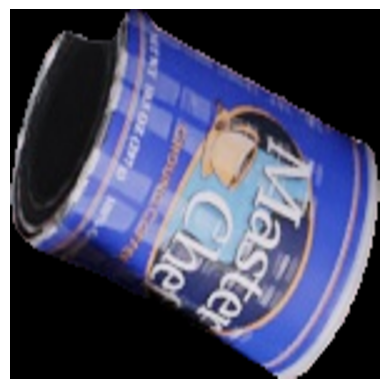

top 5 confidence scores tensor([[0.1315, 0.1302, 0.1163, 0.1124, 0.1076]], dtype=torch.float64)
final average confidence score tensor([0.1196], dtype=torch.float64)


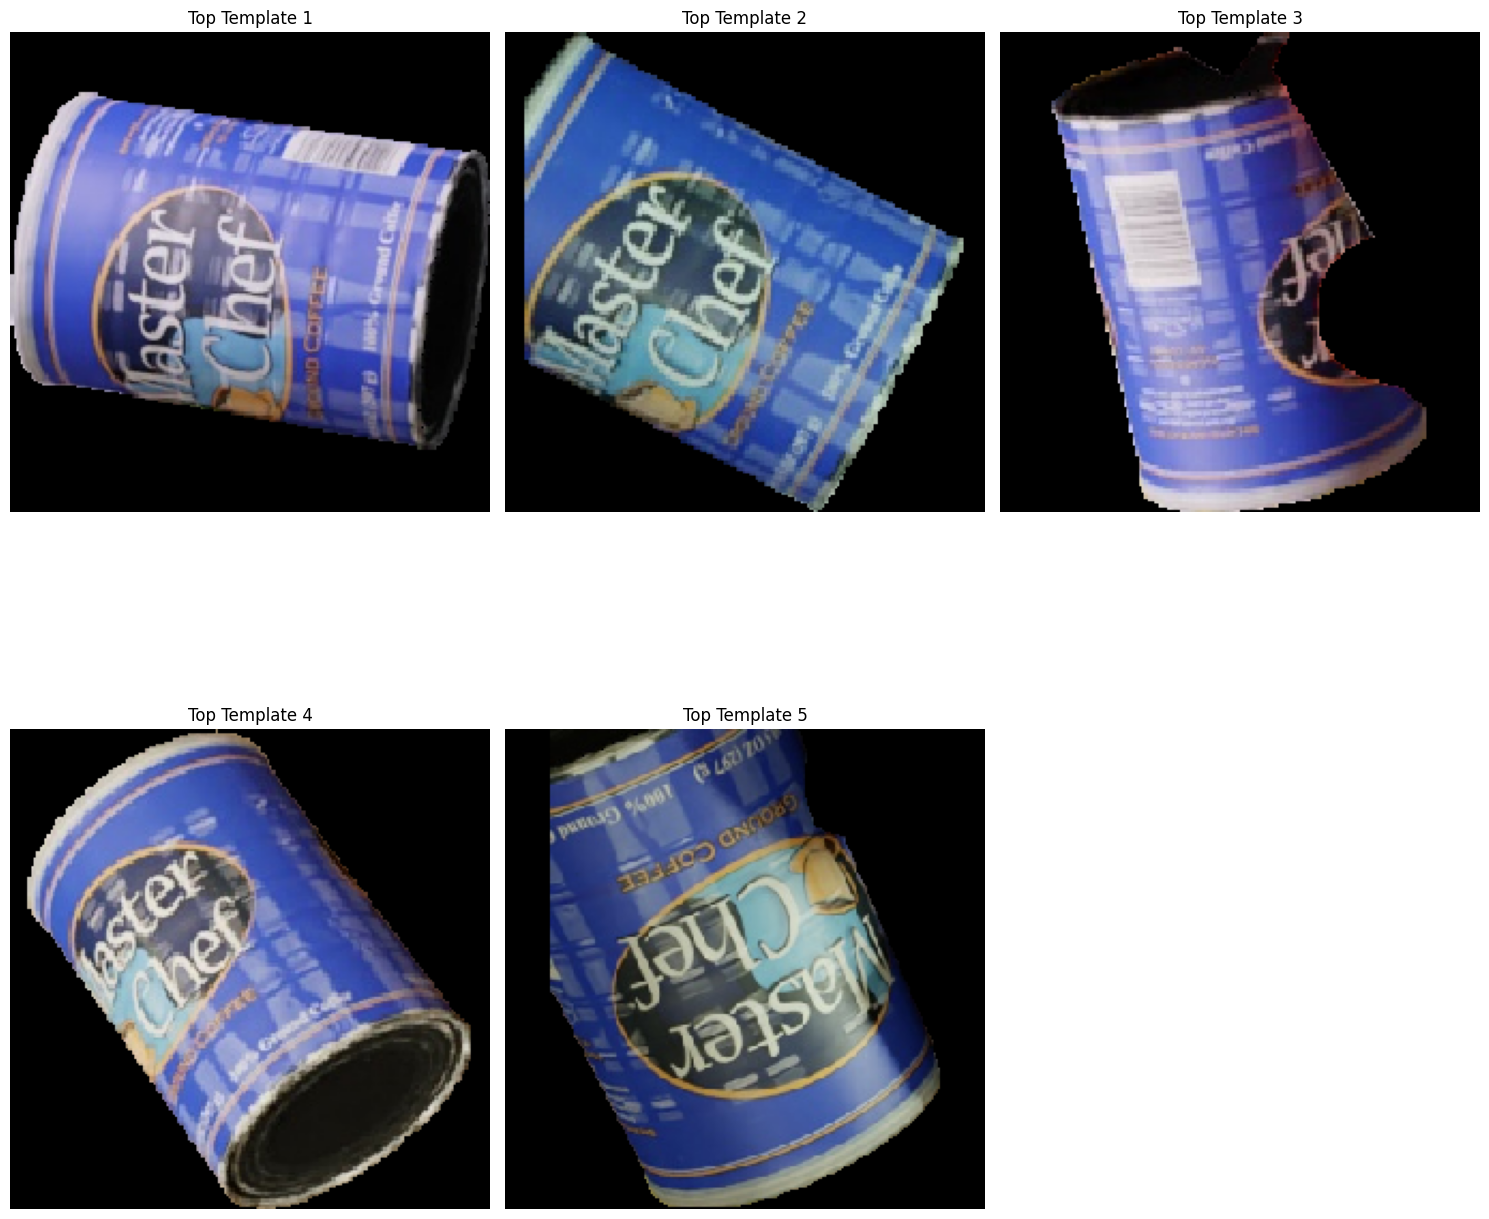

In [155]:
calculate_similarity(crop_rgb, crop_vector, concat_templates_vector, metric, synthetic=True)